# 循环神经网络RNN

到目前为止，我们遇到过两种类型的数据：表格数据和图像数据。 对于图像数据，我们设计了专门的卷积神经网络架构来为这类特殊的数据结构建模。

如果说卷积神经网络可以有效地处理空间信息， 那么本章的**循环神经网络（recurrent neural network，RNN）则可以更好地处理序列信息。 循环神经网络通过引入状态变量存储过去的信息和当前的输入，从而可以确定当前的输出。**

## 序列模型

序列模型中，当前数据跟之前观察到的数据相关

序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
- 自回归模型使用自身过去数据来预测未来
- 马尔科夫模型假设当前只跟最近少数数据相关从而简化模型

在序列模型中，因果关系指的是一个变量的变化会导致另一个变量发生变化的关系。这种关系是有方向的，即原因在前，结果在后。对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。


### 训练


#### 生成序列数据

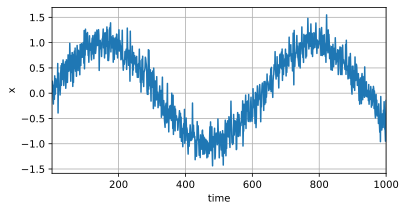

In [1]:
# 使用正弦函数和一些可加性噪声来生成序列数据
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
# 创建一个从1到T（包含T）的一维张量（tensor）
time = torch.arange(1, T + 1, dtype=torch.float32)
# 计算了time张量中每个元素的0.01倍的正弦值，然后加上噪音（一个形状为(T,)的一维张量，其中的元素是从均值为0、标准差为0.2的正态分布中随机抽取的。）
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

load_array函数：
```python
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
```

#### 将序列转换为模型的特征－标签（feature-label）对

**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**

In [10]:
# 这里使用的是马尔科夫模型假设

# tau通常代表时间滞后（time lag）或窗口大小，即用来预测下一个时间点的特征数量。
tau = 4
# 创建一个形状为(T - tau, tau)的全零张量features,用于存储每个时间点的tau个历史观测值
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # 填充feature特征：
    features[:, i] = x[i: T - tau + i]
# 把 tau后面的都做为label,即预测的目标值，确保labels是一个列向量
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)


In [11]:
train_iter

说明：假设T=10,tau = 4，x没有经过正弦处理
x = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]
填充特征处理结果：
features =   
[[0., 1., 2., 3.],  
 [1., 2., 3., 4.],  
 [2., 3., 4., 5.],  
 [3., 4., 5., 6.],  
 [4., 5., 6., 7.],  
 [5., 6., 7., 8.]]

`labels = x[tau:].reshape((-1, 1))`处理结果：
 labels =   
[[4.],  
 [5.],  
 [6.],  
 [7.],  
 [8.],  
 [9.]]



#### 定义模型并初始化

[**使用一个相当简单的架构训练模型：
一个拥有两个全连接层的多层感知机**]，ReLU激活函数和平方损失。

In [3]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

#### 训练模型

In [14]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            # print(X,y)
            # 清零之前计算的梯度，为新的梯度计算做准备
            trainer.zero_grad()
            # # 进行前向传播，计算预测值，并与真实值y一起计算损失 
            l = loss(net(X), y)
            # print("l:",l)
            # # 对损失进行求和，然后进行反向传播计算梯度
            l.sum().backward()
            # trainer.step()：根据之前计算出的梯度来更新net模型的参数。
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.084201
epoch 2, loss: 0.060404
epoch 3, loss: 0.058274
epoch 4, loss: 0.056796
epoch 5, loss: 0.060176



`l.sum().backward()`先计算损失求和原因：
前一步损失函数`l = loss(net(X), y)`是在计算的是每个样本的预测值与真实值之间的差距。我们在前面加载数据的时候，指定了批次大小16，也就是X包含了16个样本。损失函数会对每个样本分别计算损失，以张量（tensor）的形式返回，每个元素代表对应样本的损失。

先进行求和有利于减少计算量，平均效果，数值稳定性


计算损失函数：
```python
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
```

### 预测

`detach()` 方法会返回一个新的tensor，这个tensor与原始tensor x 共享数据，但是从当前计算图中分离出来。这意味着对这个新tensor的任何操作都不会影响原始计算图，也不会计算梯度。

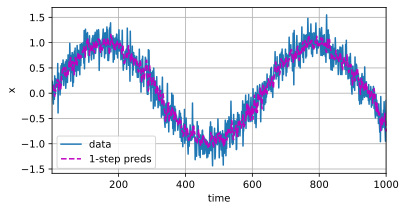

In [5]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。

使用

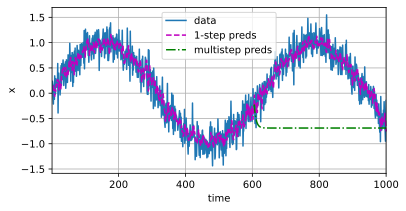

In [25]:
multistep_preds = torch.zeros(T)
# 前n_train + tau的预测结果使用实际序列的值
multistep_preds[: n_train + tau] = x[: n_train + tau]
# 后面n_train + tau以后的值，使用模型自己预测的值
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 原因错误的累积，比如未来24小时的天气预报往往相当准确， 但超过这一点，精度就会迅速下降。
对比下预测（1,4,16,64）步的结果

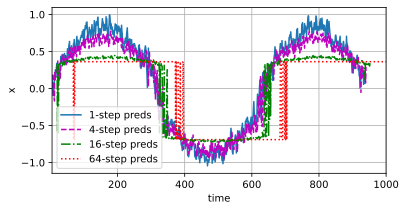

In [16]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。

## 文本预处理
本节中，我们将解析文本的常见预处理步骤。
这些步骤通常包括：

1. 将文本作为字符串加载到内存中。
1. 将字符串拆分为词元（如单词和字符）。
1. 建立一个词表，将拆分的词元映射到数字索引。
1. 将文本转换为数字索引序列，方便模型操作。

In [19]:
import collections
import re
from d2l import torch as d2l

### 读取数据
从H.G.Well的时光机器中加载文本， 为简单起见，我们在这里忽略了标点符号和字母大写。

In [20]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### 词元化
下面的tokenize函数将文本行列表（lines）作为输入， 列表中的每个元素是一个文本序列（如一条文本行）。 每个文本序列又被拆分成一个词元列表，词元（token）是文本的基本单位。 最后，返回一个由词元列表组成的列表，其中的每个词元都是一个字符串（string）。

In [21]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


### 词表
词元的类型是字符串，而模型需要的输入是数字，因此我们需要构建一个字典，通常也叫做**词表（vocabulary）**， 用来将字符串类型的词元映射到从
开始的数字索引中。

我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计， 得到的统计结果称之为**语料（corpus）**。

然后根据每个唯一词元的出现频率，为其分配一个数字索引。 **很少出现的词元通常被移除，这可以降低复杂性**。 另外，语料库中不存在或已删除的任何词元都将映射到一个特定的**未知词元“<unk>”**。 我们可以选择增加一个列表，用于保存那些被保留的词元， 例如：填充词元（“<pad>”）； 序列开始词元（“<bos>”）； 序列结束词元（“<eos>”）。

In [23]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [24]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [26]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


### 整合所有功能
在使用上述函数时，我们[**将所有功能打包到`load_corpus_time_machine`函数中**]，
该函数返回`corpus`（词元索引列表）和`vocab`（时光机器语料库的词表）。
我们在这里所做的改变是：

1. 为了简化后面章节中的训练，我们使用字符（而不是单词）实现文本词元化；
1. 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回的`corpus`仅处理为单个列表，而不是使用多词元列表构成的一个列表。

In [50]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 语言模型和数据集

假设长度为$T$的文本序列中的词元依次为$x_1, x_2, \ldots, x_T$。
于是，$x_t$（$1 \leq t \leq T$）
可以被认为是文本序列在时间步$t$处的观测或标签。
在给定这样的文本序列时，*语言模型*（language model）的目标是估计序列的联合概率

$$P(x_1, x_2, \ldots, x_T).$$

它的应用包括
- 做预训练模型(eg BERT，GPT-3)
- 生成本文，给定前面几个词，不断的使用$x \sim tp(x_t|x_1,…,x_{t-1})$来生成后续文本
- 判断多个序列中哪个更常见，e.g.“to recognize speech”vs “to wreck a nice beach

* 语言模型是自然语言处理的关键。
* $n$元语法通过截断相关性，为处理长序列提供了一种实用的模型。
* 长序列存在一个问题：它们很少出现或者从不出现。
* 齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他$n$元语法。
* 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。
* 读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。

### 读取长序列数据

#### 随机采样

In [32]:
import random
import torch
from d2l import torch as d2l

In [33]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [34]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[23, 24, 25, 26, 27],
        [13, 14, 15, 16, 17]]) 
Y: tensor([[24, 25, 26, 27, 28],
        [14, 15, 16, 17, 18]])
X:  tensor([[18, 19, 20, 21, 22],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[19, 20, 21, 22, 23],
        [29, 30, 31, 32, 33]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [ 3,  4,  5,  6,  7]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [ 4,  5,  6,  7,  8]])


#### 顺序分区

In [35]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [36]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [53]:
# 将上面的两个采样函数包装到一个类中， 以便稍后可以将其用作数据迭代器
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [54]:
# 定义了一个函数load_data_time_machine， 它同时返回数据迭代器和词表
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## 循环神经网络

循环神经网络是一类用于处理序列数据的神经网络。与传统的多层感知机（MLP）不同，RNN通过引入隐藏状态来捕捉序列中的时间依赖性。隐藏状态包含了到当前时间步为止的所有信息，使得RNN能够基于之前的输入来预测未来的输出。

RNN的基本结构包括输入层、隐藏层和输出层。与传统神经网络不同的是，RNN的隐藏层具有“记忆”功能，即其输出不仅取决于当前的输入，还取决于之前的隐藏层状态。这种记忆功能是通过隐藏层之间的循环连接实现的。

RNN的工作原理
- 输入层：接收序列数据的一个元素作为输入。
- 隐藏层：根据当前输入和上一个时间步的隐藏层状态计算新的隐藏层状态。这是通过激活函数（如tanh或ReLU）和非线性变换来实现的。
- 输出层：根据隐藏层状态生成输出。对于某些任务，如文本生成，输出层可能直接产生序列的下一个元素；对于其他任务，如情感分析，输出层可能产生一个表示情感类别的标签。

### RNN的计算公式

**隐藏状态的计算：**

$h_t = \phi(X_t W_{xh} + h_{t-1} W_{hh} + b_h)$

其中，$h_t$ 是时间步 $t$的隐藏状态，$X_t$ 是时间步 $t$ 的输入，$W_{xh}$ 和 $W_{hh}$ 是权重矩阵，$b_h$ 是偏置项，$\phi$ 是激活函数（如tanh或ReLU）。

**输出的计算：**

$ O_t = h_t W_{hq} + b_q $

其中，$O_t$ 是时间步 $t$ 的输出，$W_{hq}$ 是权重矩阵，$b_q$ 是偏置项。如果是分类任务，通常会在输出层后接一个softmax函数来计算类别的概率分布。

### 困惑度（Perplexity）
困惑度（Perplexity）是评估语言模型性能的一个常用指标。它等于交叉熵损失函数的指数形式，用于衡量模型生成文本的流利程度。困惑度越低，表示模型生成的文本越接近真实文本，性能越好。

### 梯度剪裁
梯度裁剪是一种在训练神经网络时常用的技术，主要用于防止梯度爆炸问题。
> 梯度爆炸是指在训练过程中，梯度的大小急剧增加，导致权重更新过大，从而使得模型无法收敛或者性能急剧下降的现象。为了避免这个问题，梯度裁剪通过设定一个阈值来限制梯度的大小。

如果梯度长度超过 $\theta$，那么拖影回长度$\theta$
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

## 循环神经网络的从零开始实现
本节将从头开始基于循环神经网络实现字符级语言模型。 这样的模型将在H.G.Wells的时光机器数据集上训练。

In [56]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
batch_size,num_steps=32,35
# d2l.load_data_time_machine(batch_size, num_steps)报错 
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

>  独热编码:
将每个索引映射为相互不同的单位向量：
假设词表中不同词元的数目为$N$（即`len(vocab)`），
词元索引的范围为$0$到$N-1$。
如果词元的索引是整数$i$，
那么我们将创建一个长度为$N$的全$0$向量，
并将第$i$处的元素设置为$1$。
此向量是原始词元的一个独热向量。

one_hot函数将一个小批量数据转换成三维张量， 张量的最后一个维度等于词表大小（len(vocab)）。 我们经常转换输入的维度，以便获得形状为 （时间步数，批量大小，词表大小）的输出

In [58]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape
print(X)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


### 初始化模型参数

In [61]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 循环神经网络模型

In [59]:
# 在初始化时返回隐状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

# 在一个时间步内计算隐状态和输出
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)


In [62]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### 预测

In [63]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [64]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller bztbnrxsdb'

### 梯度剪裁 

In [65]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 训练 

In [66]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [67]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 32580.1 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


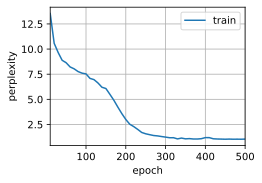

In [68]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

## 循环神经网络通过框架实现 

In [69]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

### 定义模型 

In [71]:
num_hiddens = 256
# 构造一个具有256个隐藏单元的单隐藏层的循环神经网络层rnn_layer
rnn_layer = nn.RNN(len(vocab), num_hiddens)

# 初始化隐状态，它的形状是（隐藏层数，批量大小，隐藏单元数）
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [72]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
# 将输入数据X和初始隐藏状态state传递给RNN层rnn_layer进行前向传播。
# RNN层返回输出Y和新的隐藏状态state_new。
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [73]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

### 训练与预测

In [75]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

'time travellernkkkkkkkkk'

困惑度 1.3, 151869.3 词元/秒 cuda:0
time traveller held in his hand was a glitter ofme hore we exely
traveller after the pauserequiredof aspascelis ard there wa


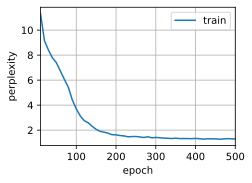

In [77]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

## 通过时间的反向传播

在循环神经网络（RNN）中，由于网络包含循环连接，导致模型的输出不仅依赖于当前时间步的输入，还依赖于之前所有时间步的输入（通过隐藏状态传递）。因此，为了训练RNN，我们需要一种方法来计算损失函数关于模型参数的梯度，这种方法就是**通过时间反向传播（Backpropagation Through Time,BPTT）**。

### BPTT的基本原理
BPTT是反向传播算法在RNN上的扩展。在训练过程中，RNN会按时间步展开成一个前馈网络，然后对每个时间步应用反向传播算法。然而，与标准的前馈网络不同，RNN中的参数（如权重和偏置）在每个时间步都是共享的。因此，在计算梯度时，需要考虑所有时间步对参数的贡献。

### BPTT的步骤
前向传播：按照时间步的顺序，将输入数据喂入RNN，并计算每个时间步的输出和隐藏状态。
计算损失：基于RNN的输出和标签计算损失函数。在序列预测任务中，通常使用交叉熵损失等。
反向传播：从最后一个时间步开始，反向计算损失函数关于每个时间步输出和隐藏状态的梯度。由于RNN中的参数是共享的，因此在计算梯度时需要累加所有时间步对同一参数的梯度。
更新参数：使用计算得到的梯度来更新RNN的参数（如权重和偏置）。这通常通过优化算法（如梯度下降）完成。